# 目的
- チョコボールを認識する
- ChainerCV利用

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np

import chainer
import random

from chainercv.chainer_experimental.datasets.sliceable import TupleDataset
from chainercv.links import FasterRCNNVGG16
from chainercv.links.model.faster_rcnn import FasterRCNNTrainChain
from chainer.datasets import TransformDataset
from chainercv import transforms
from chainer import training
from chainer.training import extensions

/home/tokita/.pyenv/versions/anaconda2-4.4.0/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import create_bbox_data as bbox

In [3]:
HOME = './'

# BoundingBoxDataSet

In [4]:
data_dir = os.path.join(HOME, 'data/res_images')

file_img_set = os.path.join(data_dir, 'images.npy')
file_bbox_set = os.path.join(data_dir, 'bounding_box_data.npy')
file_object_ids = os.path.join(data_dir, 'object_ids.npy')

file_classes = os.path.join(data_dir, 'classes.txt')

In [5]:
imgs = np.load(file_img_set)
bboxs = np.load(file_bbox_set)
objectIDs = np.load(file_object_ids)
classes = bbox.getClasses(file_classes)

In [6]:
print(imgs.shape)
print(classes)

(22, 3, 302, 402)
['choco-ball', 'choco-package']


In [7]:
dataset = TupleDataset(('img', imgs), ('bbox', bboxs), ('label', objectIDs))
print(dataset.keys)
print(len(dataset))

('img', 'bbox', 'label')
22


In [8]:
N = len(dataset)
N_train = (int)(N*0.8)
N_test = N - N_train
print('total:{}, train:{}, test:{}'.format(N, N_train, N_test))

total:22, train:17, test:5


# load Faster R-CNN Model

In [9]:
faster_rcnn = FasterRCNNVGG16(n_fg_class=len(classes), 
                              pretrained_model='imagenet')

In [10]:
# プリセットされた閾値を使用する
faster_rcnn.use_preset('evaluate')

# Set Chain

In [11]:
gpu_id = 0

In [12]:
model = FasterRCNNTrainChain(faster_rcnn)
chainer.cuda.get_device_from_id(gpu_id).use()
model.to_gpu()

# Optimizer

In [13]:
optimizer = chainer.optimizers.MomentumSGD(lr=0.001, momentum=0.9)
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer_hooks.WeightDecay(rate=0.0005))

# set data

In [14]:
class Transform(object):

    def __init__(self, faster_rcnn):
        self.faster_rcnn = faster_rcnn

    def __call__(self, in_data):
        img, bbox, label = in_data
        _, H, W = img.shape
        img = self.faster_rcnn.prepare(img)
        _, o_H, o_W = img.shape
        scale = o_H / H
        bbox = transforms.resize_bbox(bbox, (H, W), (o_H, o_W))

        # horizontally flip
        img, params = transforms.random_flip(
            img, x_random=True, return_param=True)
        bbox = transforms.flip_bbox(
            bbox, (o_H, o_W), x_flip=params['x_flip'])

        return img, bbox, label, scale

In [15]:
## データの分割
idxs = list(np.arange(N))
random.shuffle(idxs)
train_idxs = idxs[:N_train]
test_idxs = idxs[N_train:]

In [16]:
train_data = TransformDataset(dataset[train_idxs], Transform(faster_rcnn))
train_iter = chainer.iterators.SerialIterator(
    train_data, batch_size=1)
test_iter = chainer.iterators.SerialIterator(
    dataset[test_idxs], batch_size=1, repeat=False, shuffle=False)

# 学習の設定

In [17]:
updater = chainer.training.updaters.StandardUpdater(
    train_iter, optimizer, device=gpu_id)

In [18]:
n_epoch = 20
out_dir = './out'
trainer = training.Trainer(
    updater, (n_epoch, 'epoch'), out=out_dir)

In [19]:
step_size = 100 # 学習係数減少の間隔

trainer.extend(
    extensions.snapshot_object(model.faster_rcnn, 'snapshot_model.npz'),
    trigger=(n_epoch, 'epoch')) # モデルの出力. 出力タイミングは最後に指定(n_epoch毎に出力なので)
trainer.extend(extensions.ExponentialShift('lr', 0.1),
               trigger=(step_size, 'iteration')) # 学習係数”lr”を減少させる

In [20]:
log_interval = 1, 'epoch'
plot_interval = 1, 'epoch'
print_interval = 1, 'epoch'

In [21]:
trainer.extend(chainer.training.extensions.observe_lr(),
               trigger=log_interval) # LearningRateの記録

trainer.extend(extensions.LogReport(trigger=log_interval)) # trainerの経過状況をファイルに書き出す

trainer.extend(extensions.PrintReport(
    ['iteration', 'epoch', 'elapsed_time', 'lr',
     'main/loss',
     'main/roi_loc_loss',
     'main/roi_cls_loss',
     'main/rpn_loc_loss',
     'main/rpn_cls_loss',
     'validation/main/map',
    ]), trigger=print_interval)
# trainer.extend(extensions.ProgressBar(update_interval=10))

trainer.extend(
    extensions.PlotReport(
        ['main/loss'],
        file_name='loss.png', trigger=plot_interval
    ),
    trigger=plot_interval
) # ログの可視化

trainer.extend(extensions.dump_graph('main/loss'))

# Training

In [22]:
trainer.run()

iteration   epoch       elapsed_time  lr          main/loss   main/roi_loc_loss  main/roi_cls_loss  main/rpn_loc_loss  main/rpn_cls_loss  validation/main/map
17          1           5.86713       0.001       2.03428     0.476193           0.507866           0.443355           0.606865                                
34          2           10.6674       0.001       1.56503     0.524552           0.363661           0.25203            0.424783                                
51          3           15.4714       0.001       1.3792      0.52734            0.28926            0.257259           0.305342                                
68          4           20.2688       0.001       1.2624      0.514489           0.28164            0.204375           0.261897                                
85          5           25.0528       0.001       1.11533     0.498632           0.228045           0.160667           0.227987                                
102         6           29.8825       0.00

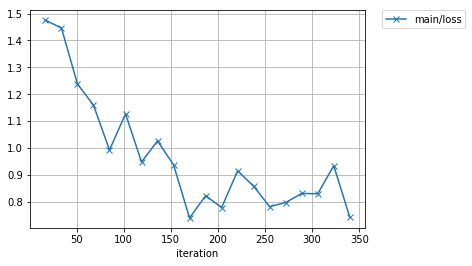

In [23]:
from IPython.display import Image
Image(filename='out/loss.png')

# Evaluate
- Testデータを入力し、チョコボール数を評価

In [45]:
from chainercv.visualizations import vis_bbox

In [24]:
test_dataset = dataset[test_idxs]

In [48]:
# 学習したモデルを呼び直す
pretrain_model = 'out/snapshot_model.npz'
model_frcnn = FasterRCNNVGG16(n_fg_class=len(classes),
                              pretrained_model=pretrain_model)
model_frcnn.to_gpu()

In [66]:
pred_list = list()
diff_list = list()
for test_data in test_dataset:
    img = test_data[0]
    tr_labels = test_data[2]
    bboxes, labels, scores = model_frcnn.predict([img])
    pred_list.append((img, bboxes[0], labels[0], scores[0]))
    print("detected choco-ball : ", np.sum(labels[0] == 0), ", true_chocoball_num : ", np.sum(tr_labels ==0))
    diff_list.append(np.sum(tr_labels ==0) - np.sum(labels[0] == 0))
print("MSE : ", np.dot(np.array(diff_list), np.array(diff_list)) / float(len(diff_list)))

detected choco-ball :  14 , true_chocoball_num :  14
detected choco-ball :  18 , true_chocoball_num :  18
detected choco-ball :  17 , true_chocoball_num :  17
detected choco-ball :  18 , true_chocoball_num :  18
detected choco-ball :  17 , true_chocoball_num :  18
MSE :  0.2


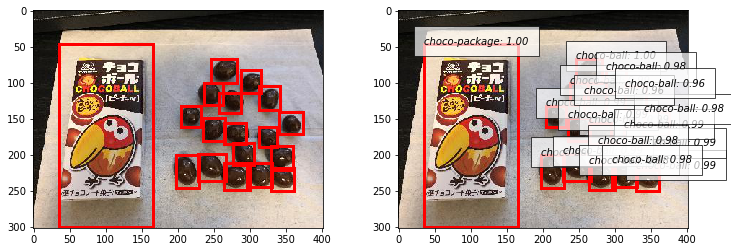

In [73]:
res = random.choice(pred_list) #pred_list[0]
fig = plt.figure(figsize=(12, 4))
ax = fig.subplots(1,2)
vis_bbox(res[0], res[1], res[2], ax=ax[0])
vis_bbox(res[0], res[1], res[2], res[3], label_names=classes, ax=ax[1])
plt.show()